# Langevin and Brownian Dynamics
## Diffusion in Brownian/Langevin dynamics (Ex1)

Consider an isolated particle or an “ideal gas” of non interacting particles. Set $m = 1$, $\sigma = 1$ and $\epsilon = 1$ as units of mass, length, energy. Set $L = 20\sigma$ and use periodic boundary conditions. Choose initial conditions as you prefer; the most convenient choice is to set all the starting positions in the origin. 

Simulate Brownian and Langevin dynamics in 3D, that is, the overdamped limit (Euler/Maruyama integrator) and the “underdamped” limit (Stochastic Velocity Verlet or with the second order integrator). Compute the mean square displacement and discuss what happens upon varying the temperature ($0.1 < T^* < 2, \gamma = \frac{1}{\tau}$) and the friction coefficient ($0.1 < \gamma \tau <100, T^* = 1$). Pick $5-10$ values in each case. Compare the results with the theory. Further measure the distribution of the displacement of the particle(s) along one axis at different times: what changes to the distribution as time progresses

---
Let's start with the Euler/Maruyama integrator 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

In [12]:
def computeBrownianTrajectories(T, gamma, dt, steps, N, m = 1, sigma = 1.0, L = 20.0):
    # Save the trajectories in r
    r = np.zeros((N, 3))
    # Mean squared distance from (0,0,0)
    msd = np.zeros(steps)
    errors = np.zeros(steps)

    noiseFactor = np.sqrt(2 * T / (m * gamma))

    for t in range(steps):
        # Sample a random displacement 
        xi = np.random.normal(loc=0.0, scale=1.0, size=(N, 3))
        # Update positions (the only term is the random noise, no external forces)
        r = r + noiseFactor * xi * np.sqrt(dt)
        msd[t] = np.mean(np.sum(r**2, axis=1))
        errors[t] = np.std(np.sum(r**2, axis=1)) / np.sqrt(N)
    return r, msd, errors

def computeLangevinTrajectories(T, gamma, dt, steps, N, m = 1, sigma = 1.0, L = 20.0):
    r = np.zeros((N, 3))
    v_thermal_std = np.sqrt(T / m)
    v = np.random.normal(loc=0.0, scale=v_thermal_std, size=(N, 3))
    msd = np.zeros(steps)
    errors = np.zeros(steps)
    # Prefactor for the stochastic term
    force_noise_mag = np.sqrt(2.0 * m * gamma * T / dt)
    # Initial force
    force = -gamma * v + np.random.normal(0.0, 1.0, (N, 3)) * force_noise_mag

    # Velocity Verlet integration
    for t in range(steps):
        # First kick
        a = force / m
        v = v + 0.5 * dt * a
        # Position update
        r = r + v * dt

        xi_new = np.random.normal(0.0, 1.0, (N, 3)) * force_noise_mag
        force_new = -gamma * v + xi_new
        # Second kick
        a_new = force_new / m
        v = v + 0.5 * dt * a_new

        force = force_new
        msd[t] = np.mean(np.sum(r**2, axis=1))
        errors[t] = np.std(np.sum(r**2, axis=1)) / np.sqrt(N)
    return r, msd, errors

Let's see what happens when we vary $T$. We'll fix the measurement time $t_0$ and observe the mean squared displacement $Var(\vec r (t)) = \langle (\vec r(t) - \langle r (t) \rangle )^2\rangle$

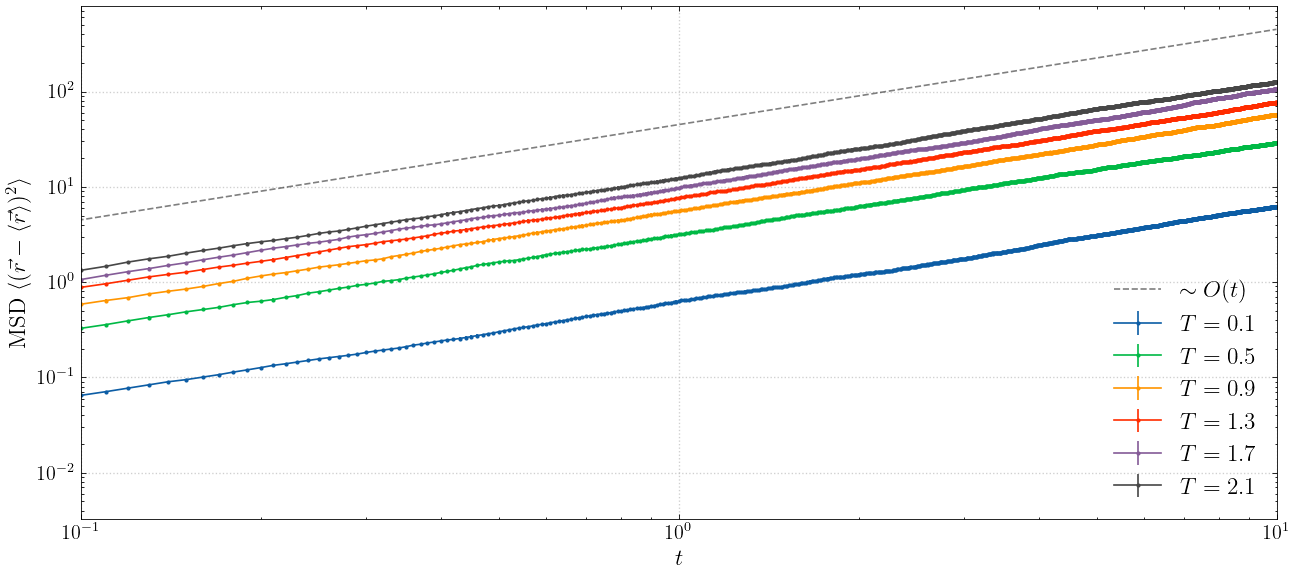

In [30]:
temperatures = np.arange(0.1, 2.2, 0.4)
            
gamma = 1.0
dt = 0.01
steps = 1000
N = 1000
msd_brownian = []
errors_msd = []
for T in temperatures:
    _, msd, errors = computeBrownianTrajectories(T, gamma, dt, steps, N)
    msd_brownian.append(msd)
    errors_msd.append(errors)

plt.figure(figsize=(11, 5), dpi = 120)
for i, T in enumerate(temperatures):
    plt.errorbar(np.arange(steps) * dt, msd_brownian[i], yerr=errors_msd[i], marker='o', markersize = 1.5, label = fr'$T={T:.1f}$')
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'MSD $\langle (\vec r- \langle \vec r \rangle)^2 \rangle$', fontsize=14)
# Reference line for diffusion
plt.plot(np.arange(steps) * dt, (np.arange(steps) * dt*45), 'k--', alpha=0.5, label=fr"$\sim O(t)$")
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.6)
plt.legend(framealpha=0.9, fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10*dt, steps*dt)   
plt.tight_layout()
plt.savefig("../../tex2/FIG/brownian_msd_vs_t.pdf", dpi = 300)
plt.show()

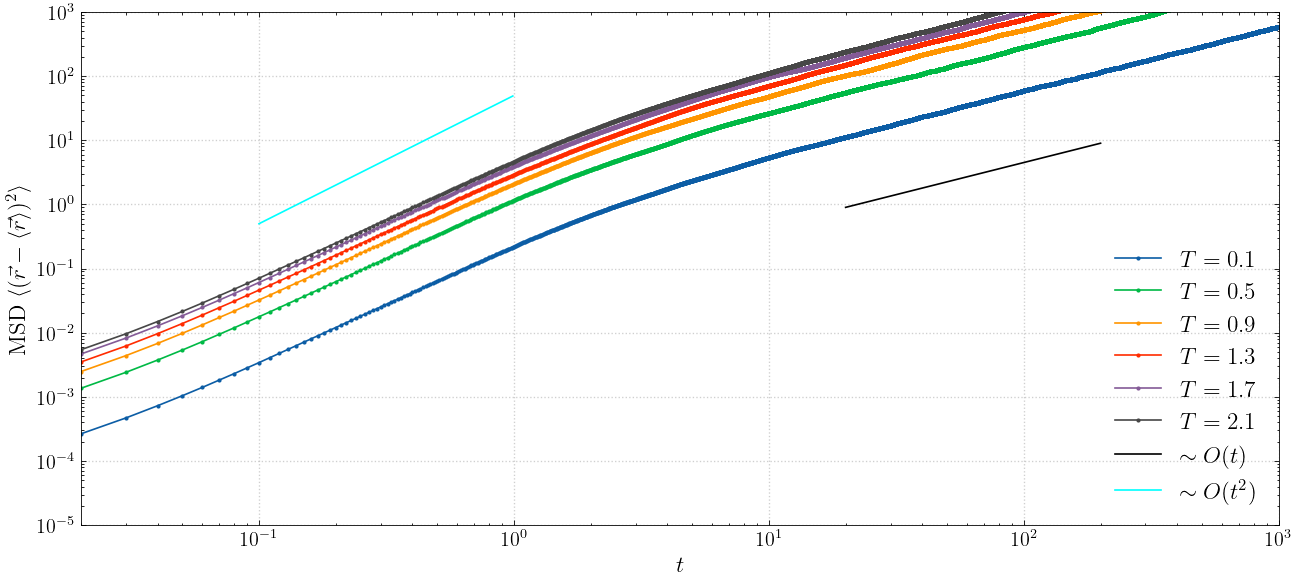

In [ ]:
temperatures = np.arange(0.1, 2.2, 0.4)
            
gamma = 1.0
dt = 0.01
steps = 100000
N = 1000
msd_langevin = []
errors_langevin = []

for T in temperatures:
    _, msd, errors = computeLangevinTrajectories(T, gamma, dt, steps, N)
    msd_langevin.append(msd)
    errors_langevin.append(errors)

plt.figure(figsize=(11, 5), dpi = 120)
for i, T in enumerate(temperatures):
    plt.plot(np.arange(steps) * dt, msd_langevin[i], marker='o', markersize = 1.5, label = fr'$T={T:.1f}$')
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'MSD $\langle (\vec r- \langle \vec r \rangle)^2 \rangle$', fontsize=14)
# Reference line for diffusion
plt.plot(np.arange(steps/50, steps/5) * dt, (np.arange(steps/50, steps/5) * dt*0.045), linestyle='-', color = "black", label=fr"$\sim O(t)$")
plt.plot(np.arange(10, steps/1000) * dt, 0.5*(np.arange(10, steps/1000)**2 * dt),linestyle='-', color = "cyan", label=fr"$\sim O(t^2)$")
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.legend(framealpha=0.9, fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim(2*dt, steps*dt)   
plt.ylim(1e-5,1e3)
plt.savefig("../../tex2/FIG/langevin_msd_vs_t.pdf", dpi = 300)
plt.show()

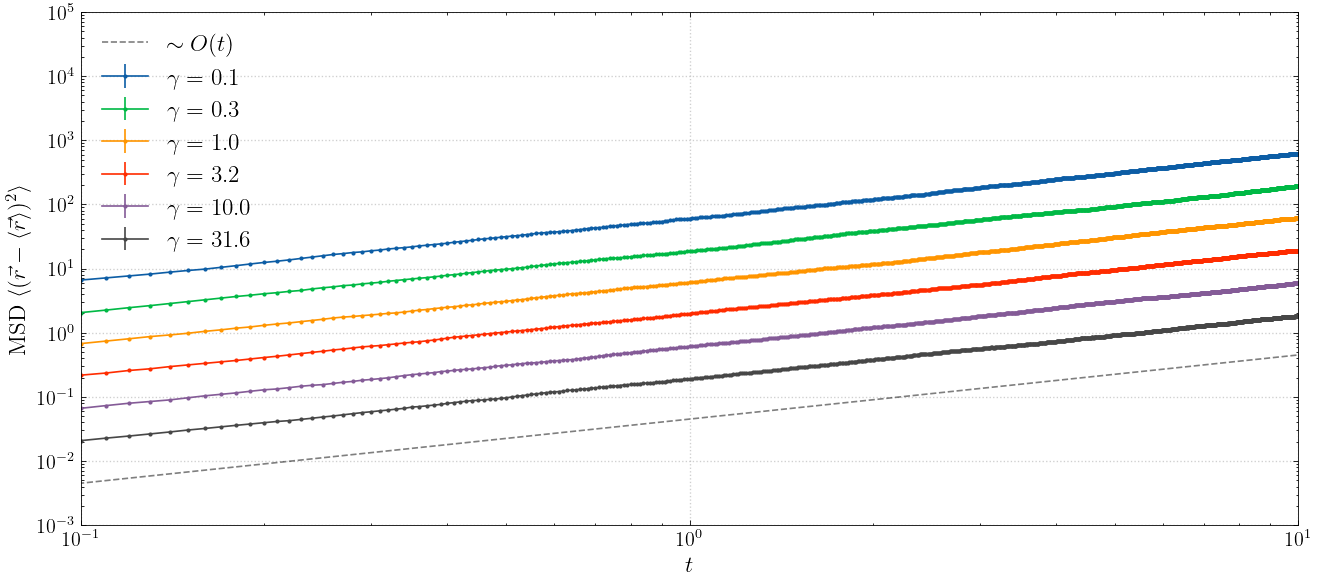

In [29]:
gammas = 10.0**np.arange(-1, 2, 0.5)
            
T = 1
dt = 0.01
steps = 1000
N = 1000
msd_brownian = []
errors_brownian = []
for gamma in gammas:
    _, msd, errors = computeBrownianTrajectories(T, gamma, dt, steps, N)
    msd_brownian.append(msd)
    errors_brownian.append(errors)

plt.figure(figsize=(11, 5), dpi = 120)
for i, gamma in enumerate(gammas):
    plt.errorbar(np.arange(steps) * dt, msd_brownian[i], yerr=errors_brownian[i], marker='o', markersize = 1.5, label = fr'$\gamma={gamma:.1f}$')
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'MSD $\langle (\vec r- \langle \vec r \rangle)^2 \rangle$', fontsize=14)
# Reference line for diffusion
plt.plot(np.arange(steps) * dt, (np.arange(steps) * dt*0.045), 'k--', alpha=0.5, label=fr"$\sim O(t)$")
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.legend(framealpha=0.9, fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10*dt, steps*dt) 
plt.ylim(1e-3, 1e5)  
plt.savefig("../../tex2/FIG/brownian_msd_vs_gamma.pdf", dpi = 300)
plt.show()

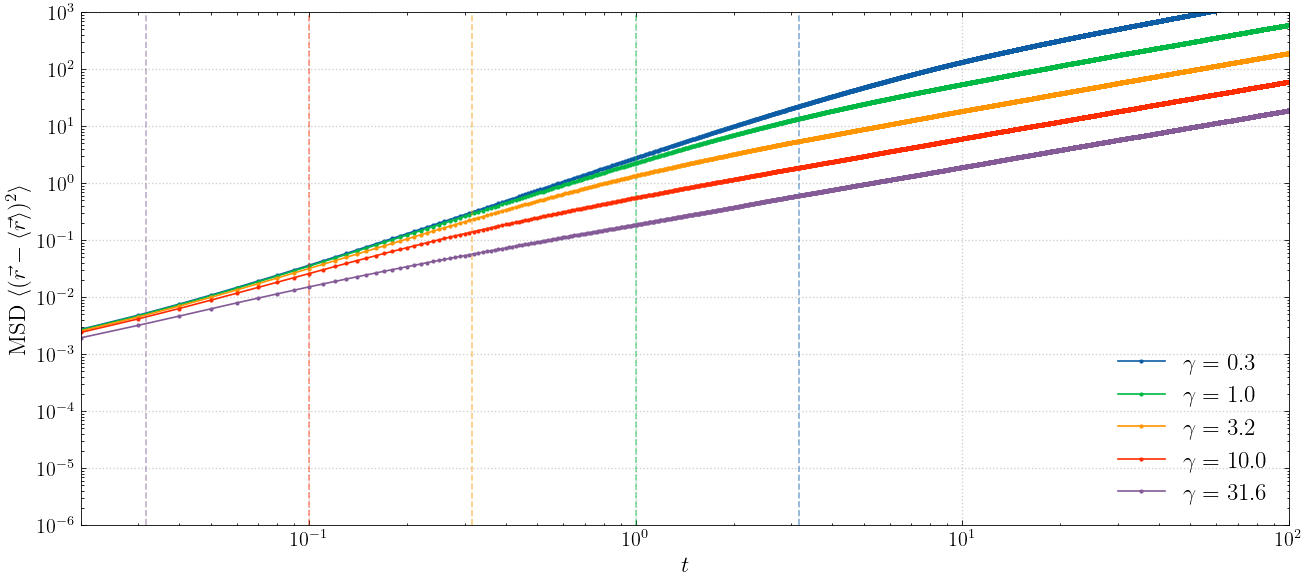

In [94]:
gammas = 10.0**np.arange(-0.5, 2, 0.5)
            
T = 1.0
dt = 0.01
steps = 10000
N = 10000
msd_langevin = []

for gamma in gammas:
    _, msd = computeLangevinTrajectories(T, gamma, dt, steps, N)
    msd_langevin.append(msd)

plt.figure(figsize=(11, 5), dpi = 120)
for i, gamma in enumerate(gammas):
    line = plt.plot(np.arange(steps) * dt, msd_langevin[i], marker='o', markersize = 1.5, label = fr'$\gamma={gamma:.1f}$')
    plt.axvline(x=1.0/gamma, linestyle='--', alpha=0.5, color=line[0].get_color())
plt.xlabel('$t$', fontsize=14)
plt.ylabel(r'MSD $\langle (\vec r- \langle \vec r \rangle)^2 \rangle$', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.legend(framealpha=0.9, fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim(2*dt, steps*dt)   
plt.ylim(1e-6,1e3)
plt.show()